# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4




**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [1]:
def H(y):
    if len(y) != 0:
      mean = np.mean(y)
      return np.mean((y - mean) ** 2)
    else:
      return 0

In [4]:

assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [6]:
def Q(X, y, j, t):
    size = len(X)
    j_col = X[:, j]
    l = y[j_col <= t]
    r = y[j_col > t]
    left_size = len(l)
    right_size = len(r)
    left_h = H(l)
    right_h = H(r)
    l_value = (left_size / size) * left_h
    r_value = (right_size / size) * right_h
    return l_value + r_value

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [7]:
class Node(object):
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        best_split_column = None
        best_threshold = None
        best_cost = H(y) 
        
        y_l = None
        y_r = None
        x_l = None
        x_r = None
        
        for i in range(len(X[0, :])):
            for j in range(len(X[:, 0])):

                cost = Q(X, y, i, X[j, i])
                
                if cost < best_cost:
                    best_cost = cost
                    best_split_column = i
                    best_threshold = X[j, i]

                    x_l = X[X[:,i] < best_threshold]
                    x_r = X[X[:,i] >= best_threshold]
                    y_l = y[X[:,i] < best_threshold]
                    y_r = y[X[:,i] >= best_threshold]
        
        return best_split_column, best_threshold, x_l, y_l, x_r, y_r
    
    def is_terminal(self, node, y):
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        if self.is_terminal(node, y):
            node.is_terminal = True
            return
   
        best_split_column, best_threshold, x_l, y_l, x_r, y_r = self.best_split(X, y)
        
        if best_split_column is None:
            node.is_terminal = True
            return
        if len(x_l) < self.min_samples_split:
            node.is_terminal = True
            return
        if len(x_r) < self.min_samples_split:
            node.is_terminal = True
            return
        
        node.column = best_split_column
        node.threshold = best_threshold
        
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_l)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_r)

        self.grow_tree(node.left, x_l, y_l)
        self.grow_tree(node.right, x_r, y_r)
        

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):

        if node.is_terminal:
          return node.prediction
        
        target = Node()
        
        if x[node.column] > node.threshold:
          target = node.right
        else:
          target = node.left

        return self.get_prediction(target, x)
    
    def predict(self, X):
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [11]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/estimator_checks.py:3617: FutureWarning: As of scikit-learn 0.23, estimators should expose a n_features_in_ attribute, unless the 'no_validation' tag is True. This attribute should be equal to the number of features passed to the fit method. An error will be raised from version 1.0 (renaming of 0.25) when calling check_estimator(). See SLEP010: https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep010/proposal.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/estimator_checks.py:3652: FutureWarning: As of scikit-learn 0.23, estimators should have a 'requires_y' tag set to the appropriate value. The default value of the tag is False. An error will be raised from version 1.0 when calling check_estimator() if the tag isn't properly set.
  warnings.warn(warning_msg, FutureWarning)


### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

In [12]:
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

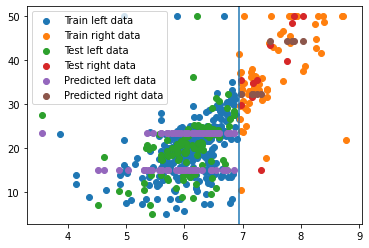

In [13]:
data_set = load_boston()

x = data_set.data
y = data_set.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

tree = MyDecisionTreeRegressor(2)
tree.fit(x_train, y_train)

threshold =  tree.tree_.threshold
x_train_column = x_train[:, tree.tree_.column]
x_test_column = x_test[:, tree.tree_.column]
y_predcted = tree.predict(x_test)

x_arr = [x_train[x_train_column <= threshold][:, tree.tree_.column],
           x_train[x_train_column > threshold][:, tree.tree_.column],
           x_test[x_test_column <= threshold][:, tree.tree_.column],
           x_test[x_test_column > threshold][:, tree.tree_.column],
           x_test[x_test_column <= threshold][:, tree.tree_.column],
           x_test[x_test_column > threshold][:,tree.tree_.column]]

y_arr = [y_train[x_train_column <= threshold],
           y_train[x_train_column > threshold],
           y_test[x_test_column <= threshold],
           y_test[x_test_column > threshold],
           y_predcted[x_test_column <= threshold],
           y_predcted[x_test_column > threshold]]

labels = ['Train left data', 'Train right data', 'Test left data', 'Test right data', 'Predicted left data', 'Predicted right data']

for i in range(len(x_arr)):
  plt.scatter(x_arr[i], y_arr[i], label=labels[i])

plt.legend()
plt.axvline(threshold)
plt.show()

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
params = {"max_depth" : range(2, 10), 'min_samples_leaf' : range(2, 10)}

In [18]:
tree = MyDecisionTreeRegressor()
tree.fit(x_train, y_train)

clf = GridSearchCV(tree, params, scoring='neg_root_mean_squared_error', cv=5)
clf.fit(x_train, y_train)

print('Best params: ', clf.best_params_)
print('Best score: %.3f'% clf.best_score_)

Best params:  {'max_depth': 9, 'min_samples_leaf': 2}
Best score: -4.968


In [19]:
prediction_1 = tree.predict(x_test)

tree = MyDecisionTreeRegressor(max_depth=9, min_samples_leaf=2)
tree.fit(x_train, y_train)

MyDecisionTreeRegressor(max_depth=9, min_samples_leaf=2)

In [20]:
from sklearn.metrics import mean_absolute_error

prediction_2 = tree.predict(x_test)

print("MAE 1: " + str(mean_absolute_error(prediction_1, y_test)))
print("MAE 2: " + str(mean_absolute_error(prediction_2, y_test)))

MAE 1: 3.1693400799746074
MAE 2: 2.4848923906306433


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [23]:
def get_bias_variance(estimator, x, y, n_iter):


SyntaxError: ignored

In [ ]:
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, x_train, y_train, 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Degrees of freedom <= 0 for slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


(22.374397870007858, 5.070790610978789)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

In [21]:
# YOUR CODE HERE

По графику можно заметить, что bias уменьшается с увеличеснием глубины, а variance почти не меняет свое значение, но можно заметить небольшое увеличение в целом

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [22]:
from sklearn.ensemble import BaggingRegressor

# YOUR CODE HERE

График похож на предыдущий. Bias уменьшается с увеличением глубины дерева. Variance уменьшается. В теории bias или уменьшается, или не меняется. А variance должна уменьшаться в теории. Результаты соответствуют теории.

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

FileNotFoundError: ignored

### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


# YOUR CODE HERE
# define column_transformer 

In [ ]:
# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to implement one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

To get method that you have to implement, run cell below and input your name in Russian (for example, if you input Андрей, you will see that user with this name should implement xgboost)

In [ ]:
def assign_method():
    name = input()
    methods = ['xgboost', 'lightgbm', 'catboost']
    idx = sum([ord(x) for x in list(name)]) % 3
    print('Реализуйте', methods[idx])
    
assign_method()

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [ ]:
# YOUR CODE HERE